In [78]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(1)

In [79]:
# MODEL CONSTANTS
n_realizations = 2
N = 100 # number of observations
D = 200 
pstar = 20 # number of non-zero predictors
sigma = 1 # noise parameter

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 1

# TESTING
prob_1 = pstar / D
alphas_adj = jnp.zeros(D)
alphas_adj += (prob_1) / (1-prob_1)
alphas_nonadj = jnp.ones(D)
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lams = [1, 1/10]

<h1> Generating Data </h1>

$$\begin{align*} 
y_i &\sim \sum_{j=1}^D \beta_jx_j + \epsilon_i \\
\epsilon_i &\sim N(0, \sigma^2), \;\; i = 1, ..., N
\end{align*}$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [80]:
def generate_data(A, sigma):
  """
  Generate synthetic data.

  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real A: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  X = np.random.normal(size=(N, D)) # NxD
  beta_star = np.zeros([D]) # Initialise
  beta_star[:pstar] += A   # Add signal
  Y = jnp.dot(X, beta_star) # Y = X * beta
  Y += np.random.normal(0, sigma, size=N)  # Add noise to Y
  return X, Y

<h2> Defining the Model </h2>

$$\begin{align*} 
y_i &\sim \sum_{j=1}^D \beta_jX_j + \epsilon_i \\
\beta_j &= \gamma_jA\\
\gamma_j &= \sigma \left(\frac{L_j + \log\alpha_j}{\lambda}\right) \text{  for   } j = 1, ..., D \\
L_j &= \log (U_j) - \log (1-U_j)\\
U_j &\sim \text{Uniform}(0, 1)
\end{align*}$$




Note that in order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [81]:
def model(alphas, lam, X=None, Y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter
    '''
    assert X.shape == (N, D), "X shape is {X.shape}. Should be (N, D)"
    assert Y.shape == (N, ), "Y.shape is {Y.shape}. Should be (N, )"
    assert alphas.shape == (D, ), "alphas.shape is {alphas.shape}. Should be (D, )"

    U = numpyro.sample("U", dist.Uniform(0, 1).expand((n_realizations, D))) #nxD
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) #nxD
    alphas_mult = jnp.array([alphas]*n_realizations) #nxD
    assert alphas_mult.shape == (n_realizations, D), f"alphas_mult.shape is {alphas_mult.shape}. Should be ({n_realizations}, {D})"

    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) #nxD
    kappas = numpyro.deterministic("kappas", 1 - gammas) #nxD
    y_mean = jnp.dot(X, gammas.mean(axis=0)) #NxD * Dx1
    y = numpyro.sample("Y", dist.Normal(y_mean, sigma), obs=Y) #Nx1 

In [82]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [83]:
def concrete(all_data, lam, alphas):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mses: size (D,)
       arr kappas: length len(A_values) * D
       arr mean_gammas: size (D,)
       arr betas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    kappas = []

    for A, data in all_data.items():
        X, Y = data
        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, Y=Y)
        samples = mcmc.get_samples()

        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run
        mean_gammas = mean_gammas.mean(axis=0) # mean across N
        assert mean_gammas.shape == (D, ), f"Shape is {mean_gammas.shape}. Should be (D, )"

        kappas.extend(samples['kappas'])
        
    return kappas, mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [84]:
all_mses = dict()
mean_mses = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for A in A_values:
    all_data[A] = generate_data(A=A, sigma=1) 

for lam in lams:
    all_mses[lam] = [[], []]
    mean_betas[lam] = [[], []]
    i = 0
    for alpha in [alphas_adj, alphas_nonadj]:
        kappas, gammas, all_samples, mcmc = concrete(all_data, lam, alpha)
        all_mses[lam][i] = dict()
        mean_betas[lam][i] = dict()

        for A in A_values:
            beta_star = np.zeros(D)
            beta_star[:pstar] = A
            estimated_betas = gammas * beta_star
            mses = (estimated_betas-beta_star)**2

            all_mses[lam][i][A] = np.array(mses)
            all_kappas[i] = kappas
            mean_gammas[i] = gammas
            mean_betas[lam][i][A] = estimated_betas
            all_mcmc_runs.append(mcmc)
            print('done')
        i += 1

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [85]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    U[0,0]      1.00      0.00      1.00      1.00      1.00   1531.33      1.00
    U[0,1]      1.00      0.00      1.00      1.00      1.00   1113.94      1.00
    U[0,2]      1.00      0.00      1.00      1.00      1.00   1432.75      1.00
    U[0,3]      1.00      0.00      1.00      1.00      1.00   1778.28      1.00
    U[0,4]      1.00      0.00      1.00      1.00      1.00   1026.80      1.00
    U[0,5]      1.00      0.00      1.00      1.00      1.00   1754.95      1.00
    U[0,6]      1.00      0.00      1.00      1.00      1.00   1463.07      1.00
    U[0,7]      1.00      0.00      1.00      1.00      1.00   1755.21      1.00
    U[0,8]      1.00      0.00      1.00      1.00      1.00   1496.52      1.00
    U[0,9]      1.00      0.00      1.00      1.00      1.00   1592.44      1.00
   U[0,10]      1.00      0.00      1.00      1.00      1.00   1390.72      1.00
   U[0,11]      1.00      0

<h1> Results </h1>

Text(0.5, 0, 'Entry #')

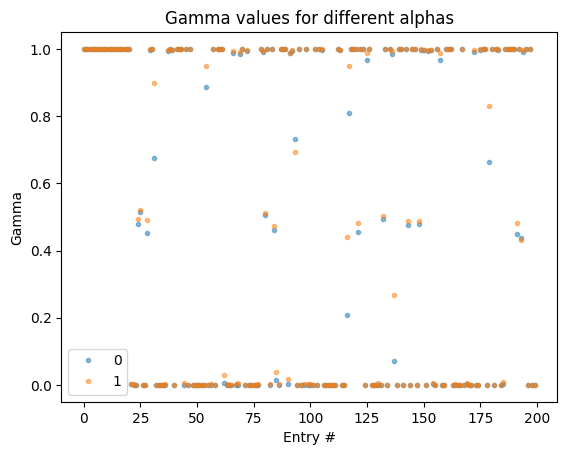

In [92]:
for i in mean_gammas:
    plt.plot(range(len(mean_gammas[i])), mean_gammas[i], '.', label=i, alpha=0.5)
plt.legend()
plt.title("Gamma values for different alphas")
plt.ylabel("Gamma")
plt.xlabel("Entry #")

Text(0.5, 0.98, 'True Beta vs. Estimated Beta')

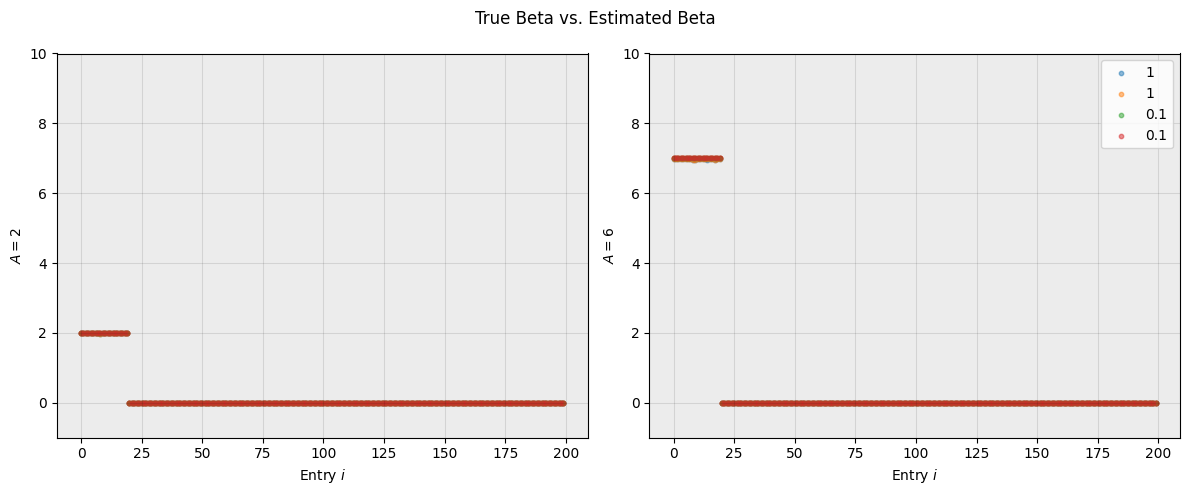

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="tight")
for ax in [ax1, ax2]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])

beta_star_7 = np.zeros(D)
beta_star_7[:pstar] = 7
beta_star_2 = np.zeros(D)
beta_star_2[:pstar] = 2

ax1.scatter(range(D), beta_star_2, color='red', s=10) # plot actual betas
ax2.scatter(range(D), beta_star_7, color='red', s=10) 
for lam in lams:
    ax1.scatter(range(len(mean_betas[lam][0][2])), mean_betas[lam][0][2], s=10, alpha=0.5, label=lam)
    ax1.scatter(range(len(mean_betas[lam][1][2])), mean_betas[lam][1][2], s=10, alpha=0.5, label=lam)
    ax2.scatter(range(len(mean_betas[lam][0][7])), mean_betas[lam][0][7], s=10, alpha=0.5, label=lam)
    ax2.scatter(range(len(mean_betas[lam][1][7])), mean_betas[lam][1][7], s=10, alpha=0.5, label=lam)

# add labels to graph
ax1.set(ylabel=r'$A=2$', xlabel=r'Entry $i$')
ax2.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
plt.legend()
fig.suptitle("True Beta vs. Estimated Beta")



In [88]:
for lam in lams:
    mean_mses[lam] = dict()
    mean_mses[lam][0] = dict()
    mean_mses[lam][1] = dict()
    for A in A_values:
        mean_mses[lam][0][A] = all_mses[lam][0][A].mean()
        mean_mses[lam][1][A] = all_mses[lam][1][A].mean()

In [89]:
mean_mses

{1: {0: {1: 1.4496056e-06,
   2: 5.7984225e-06,
   3: 1.3046387e-05,
   4: 2.319369e-05,
   5: 3.6240195e-05,
   6: 5.2185547e-05,
   7: 7.1030445e-05,
   8: 9.277476e-05,
   9: 0.000117417854,
   10: 0.00014496078},
  1: {1: 1.4303292e-06,
   2: 5.721317e-06,
   3: 1.28729935e-05,
   4: 2.2885268e-05,
   5: 3.5758163e-05,
   6: 5.1491974e-05,
   7: 7.008614e-05,
   8: 9.154107e-05,
   9: 0.000115857634,
   10: 0.00014303265}},
 0.1: {0: {1: 1.3499148e-08,
   2: 5.399659e-08,
   3: 1.2149711e-07,
   4: 2.1598636e-07,
   5: 3.3747037e-07,
   6: 4.8598844e-07,
   7: 6.6146043e-07,
   8: 8.6394544e-07,
   9: 1.0934205e-06,
   10: 1.3498815e-06},
  1: {1: 5.5761324e-09,
   2: 2.230453e-08,
   3: 5.018322e-08,
   4: 8.921812e-08,
   5: 1.3941151e-07,
   6: 2.0073288e-07,
   7: 2.7323546e-07,
   8: 3.5687248e-07,
   9: 4.5167e-07,
   10: 5.5764605e-07}}}

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

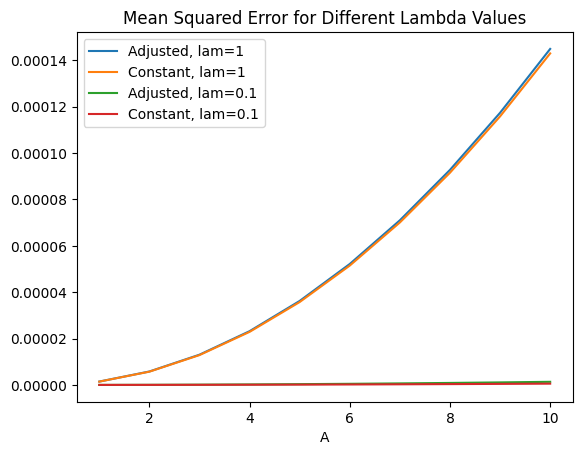

In [90]:

for lam in lams:
    plt.plot(mean_mses[lam][0].keys(), mean_mses[lam][0].values(), label=f'Adjusted, {lam=}')
    plt.plot(mean_mses[lam][1].keys(), mean_mses[lam][1].values(), label=f'Constant, {lam=}')

ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

Text(0.5, 1.0, 'Kappa values for different lambdas')

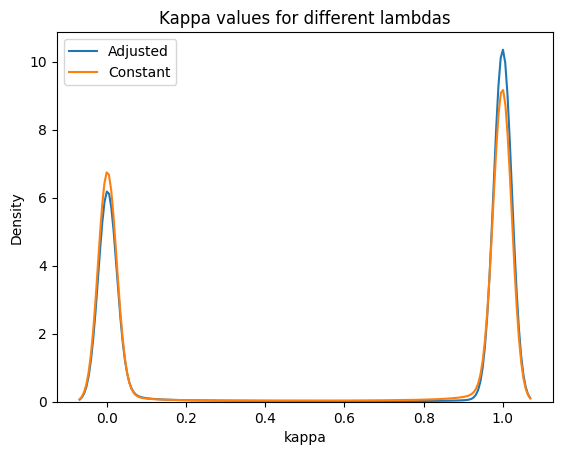

In [91]:
for i in [0,1]:
    all_kappas[i] = np.ndarray.flatten(np.array(all_kappas[i]))
sns.kdeplot(all_kappas[0], label=f'Adjusted')
sns.kdeplot(all_kappas[1], label=f'Constant')
plt.legend()
plt.xlabel("kappa")
plt.title("Kappa values for different lambdas")